In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import OrdinalEncoder

from matplotlib import style
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
plt.rcParams["figure.figsize"] = (10,8)

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None


In [102]:
df = pd.read_csv("data/insurance.csv", index_col = 0)
df.head()

,sex,smoker,region,age,bmi,children,charges
0,female,yes,southwest,19.000000,27.900,0.0,16884.92400
1,male,no,southeast,18.000000,33.770,1.0,1725.55230
2,male,no,southeast,28.000000,33.000,3.0,4449.46200
3,male,no,northwest,33.000000,22.705,0.0,21984.47061
4,male,no,northwest,39.171927,28.880,0.0,3866.85520


### 1. Gestión de outliers

In [29]:
df_numericas = df.select_dtypes(include=np.number)

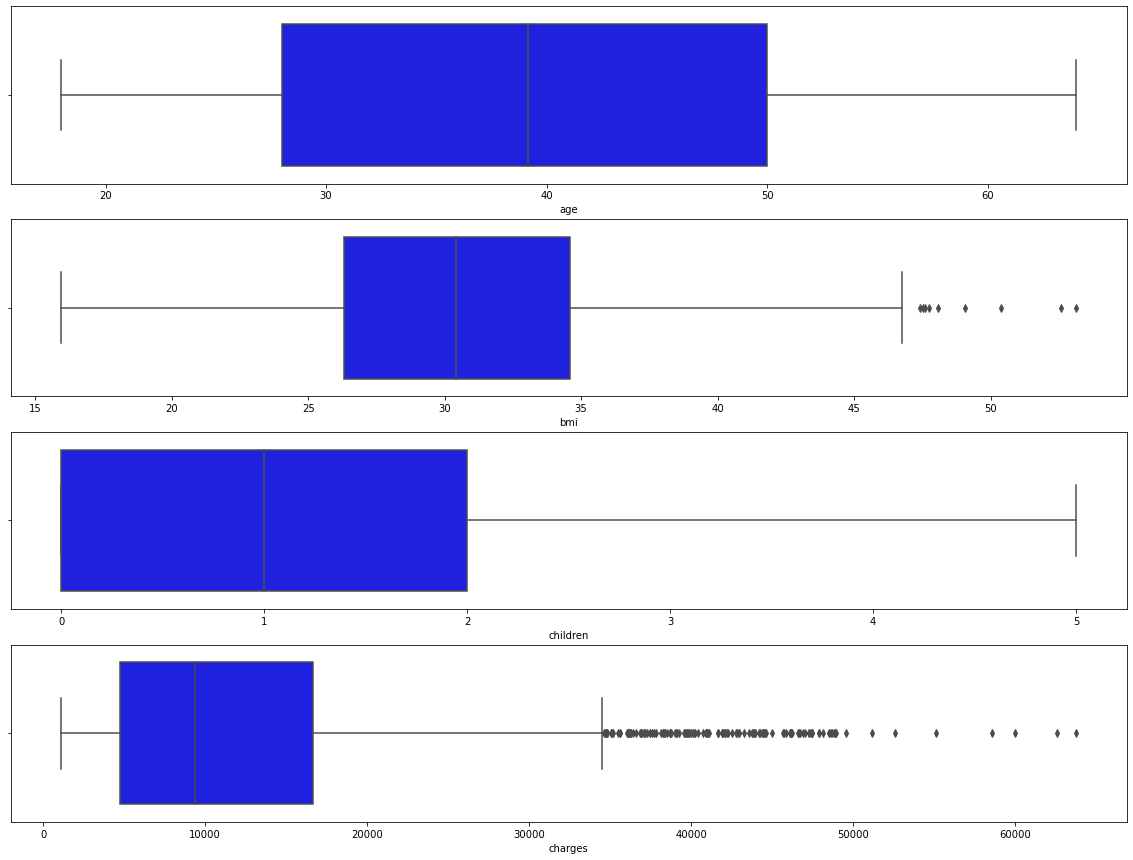

In [70]:
fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_numericas.columns)):
    sns.boxplot(x=df_numericas.columns[i], data=df_numericas, ax=ax[i], color="blue")
plt.show()

In [44]:
def detectar_outliers(lista_columnas, dataframe): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = 1.5 * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [56]:
lista_columnas = df_numericas.columns
ind = detectar_outliers(lista_columnas, df)


#### 1.1. Outliers charges

In [54]:
seleccion_charges=list(ind["charges"])
df_outliers_charges = df.iloc[seleccion_charges]

In [57]:
def porcentajes_variables_nonum(lista_columnas, dataframe):

    for col in lista_columnas:
        porcentajes = (dataframe[col].value_counts() / len(dataframe)) * 100
        porcentajes_redondeados = round(porcentajes, 2)
        print(f"% valores columna: {col}")
        print(porcentajes_redondeados)
        print(f" ")

In [58]:
porcentajes_variables_nonum(["smoker"],df_outliers_charges)

% valores columna: smoker
yes    96.4
no      3.6
Name: smoker, dtype: float64
 


En los outliers detectados en charges comprobamos que el 96.4 % de los mismos corresponden a fumadores, como habíamos comprobado en el EDA los fumadores por norma general cuentan con los mayores cargos en el set de datos.

#### 1.2. Outliers bmi

In [63]:
seleccion_bmi=list(ind["bmi"])
valores= set(seleccion_bmi)

In [62]:
df_sin_outliers_bmi = df.copy()

In [64]:
final = df_sin_outliers_bmi.drop(df_sin_outliers_bmi.index[list(valores)] )

In [65]:
df.select_dtypes(include = np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.171927,13.332170,18.0000,28.00000,39.171927,50.000000,64.00000
bmi,1338.0,30.671933,6.077385,15.9600,26.31500,30.400000,34.595000,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000000,2.000000,5.00000
charges,1338.0,13273.160228,12109.976231,1121.8739,4740.28715,9382.033000,16639.912515,63770.42801


In [66]:
final.select_dtypes(include = np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
age,1329.0,39.168577,13.324924,18.0000,28.0000,39.171927,50.00000,64.00000
bmi,1329.0,30.545941,5.898555,15.9600,26.2900,30.360000,34.43000,46.75000
children,1329.0,1.096313,1.207928,0.0000,0.0000,1.000000,2.00000,5.00000
charges,1329.0,13215.089879,11997.214209,1121.8739,4738.2682,9361.326800,16586.49771,62592.87309


Los outliers en la columna bmi corresponden a personas categorizadas como obesas de clase III. Para este estudio lo vamos a considerar un dato relevante y no los vamos a reemplazar, además podemos ver que no impactan de forma significativa a la media (independientemente de estos valores se sitúa en un 30).

### 2. Encoding

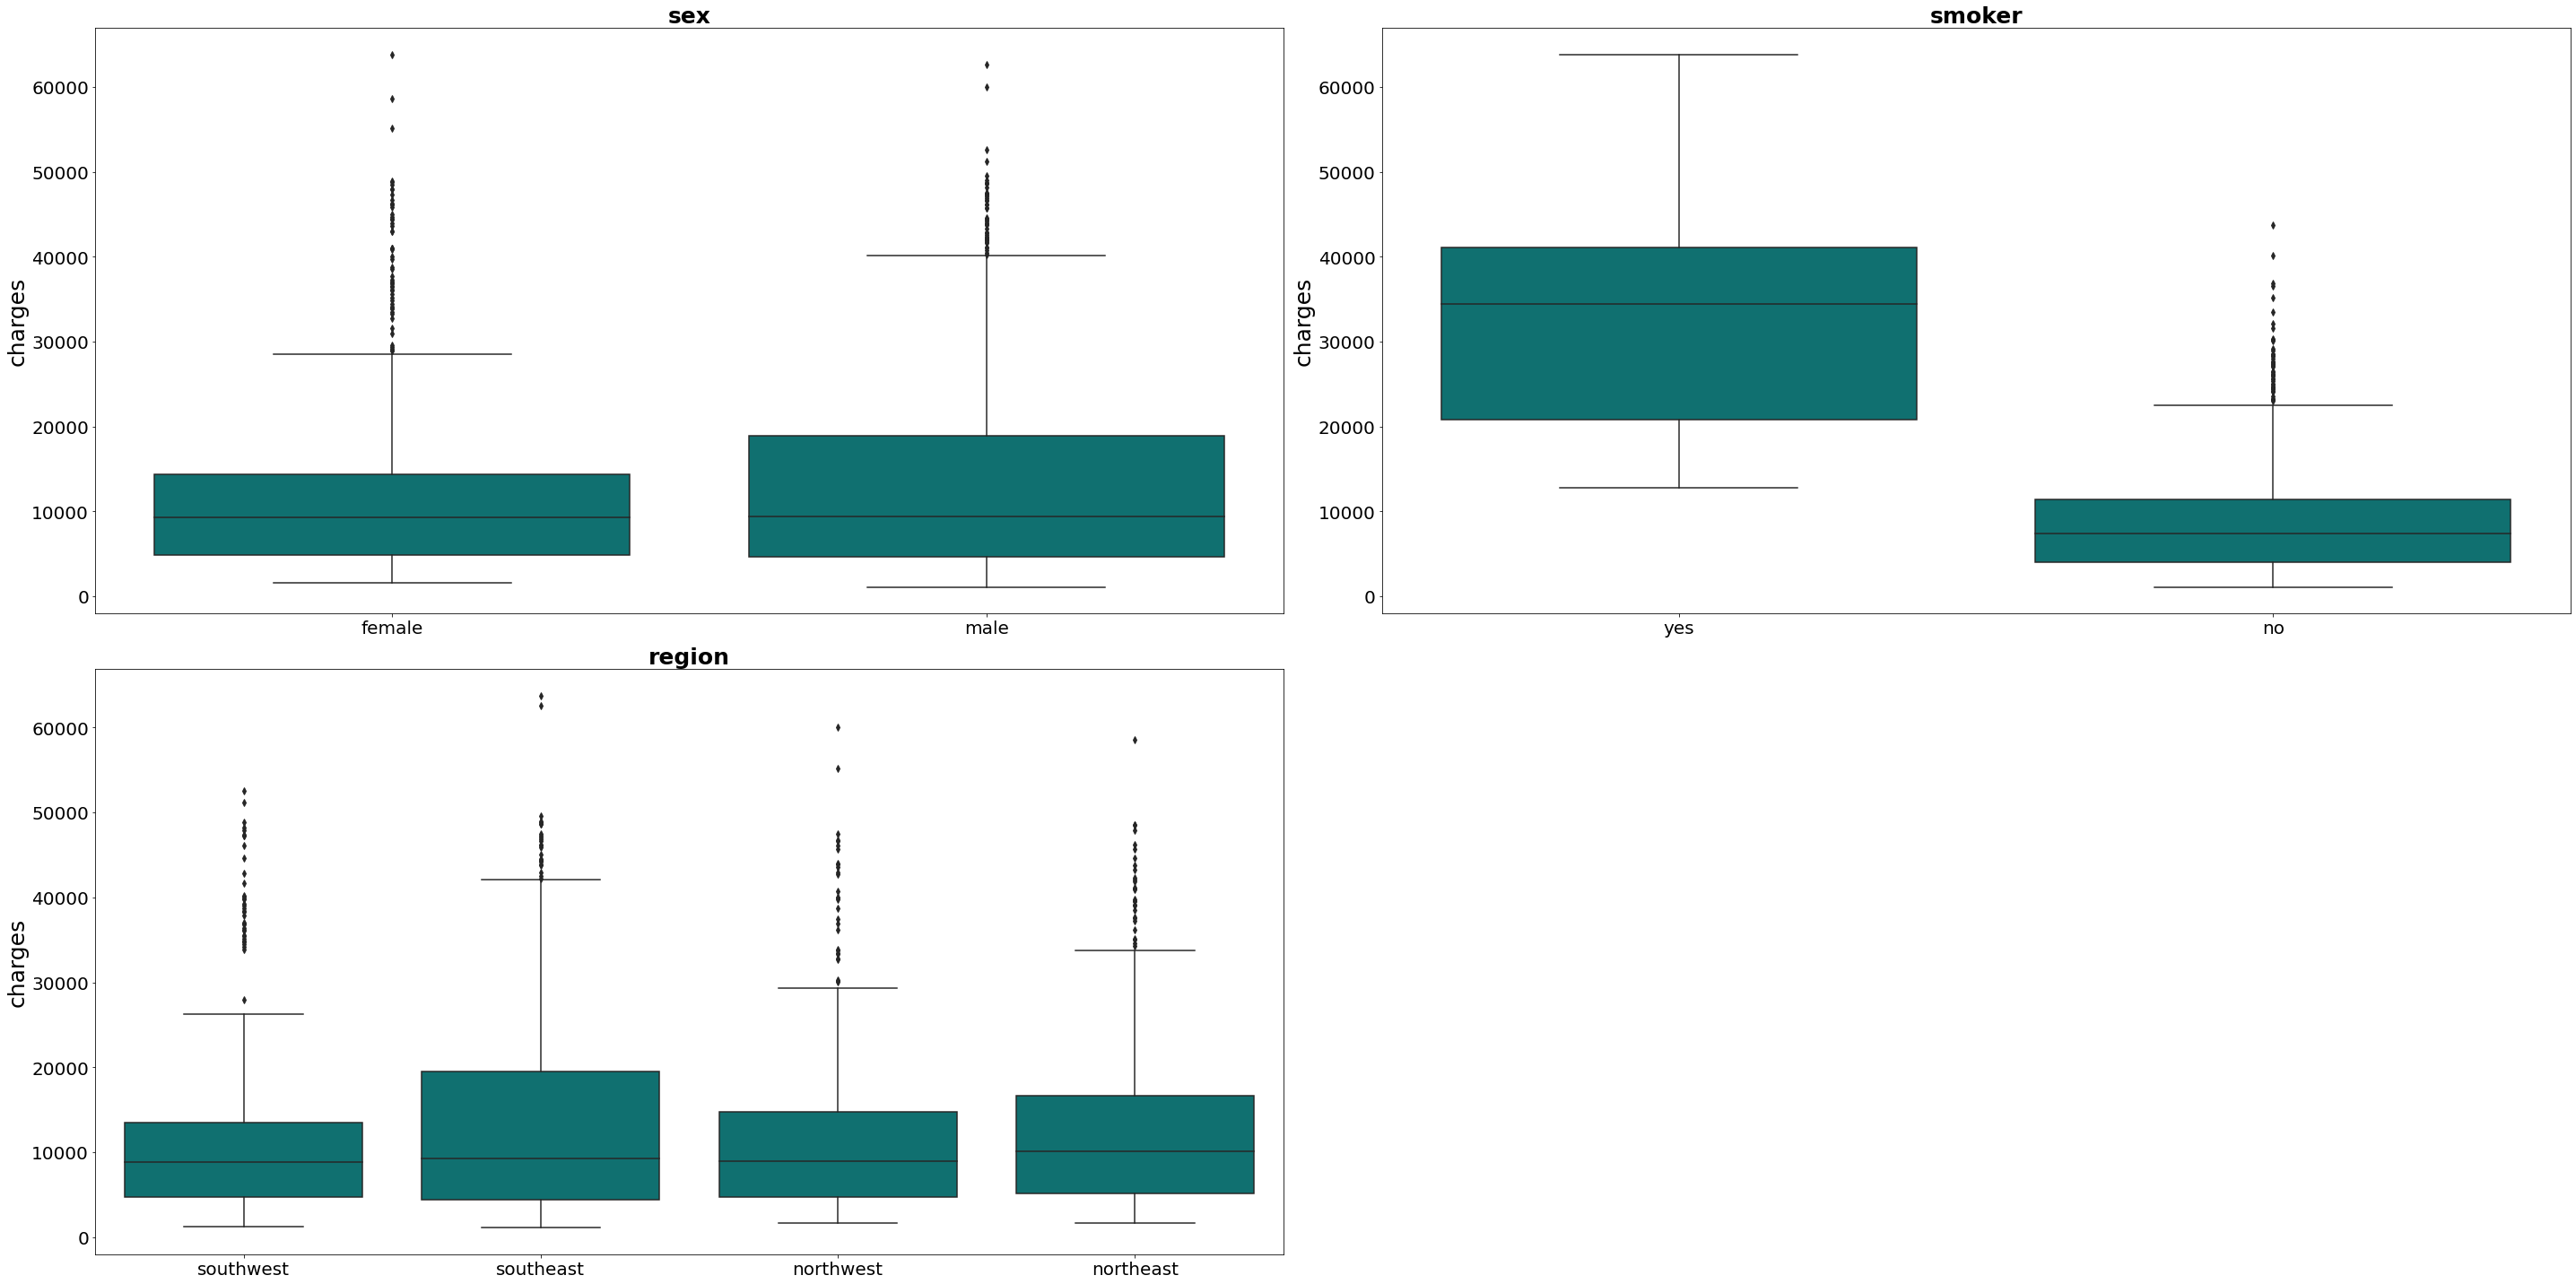

In [68]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (40, 20))


axes = axes.flat

columnas_cat = df.select_dtypes(include = ["object", "category"]).columns

for i, colum in enumerate(columnas_cat): 
    sns.boxplot(
        data = df,
        x = colum,
        y = "charges",
        color = "teal", 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 25, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel( "charges", fontsize = 25)

fig.delaxes(axes[-1])

fig.tight_layout();

### 2.1. Variables sin orden 

Las variables sin orden son "sex" y "region", utilizaremos Label Encoding para modificarlas.

In [103]:
le = LabelEncoder()

In [104]:
def label_encoder(df, columnas):
    for col in df[columnas].columns:
        nuevo_nombre = col + "_encoded"
        df[nuevo_nombre] = le.fit_transform(df[col])
        #borrado de las columnas encodeadas (rev)
        df.drop([col], axis = 1, inplace = True)
    return df

In [105]:
df = label_encoder(df, ["region", "sex"])

In [107]:
df.head(2)

,smoker,age,bmi,children,charges,region_encoded,sex_encoded
0,yes,19.0,27.90,0.0,16884.9240,3,0
1,no,18.0,33.77,1.0,1725.5523,2,1


### 2.1. Variables con orden 

La variable con orden que vamos a modificar es "smoker", utilizando para ello Ordinal Encoding.

In [108]:
def ordinal_encoder1(df, columna, orden_valores):
    
    # iniciamos el método y aplicamos la transformación a los datos. 
    ordinal = OrdinalEncoder(categories = [orden_valores], dtype = int)

    transformados_oe = ordinal.fit_transform(df[[columna]])
    
    # lo convertimos a dataframe
    oe_df = pd.DataFrame(transformados_oe)
    # cambiamos el nombre de la columna
    oe_df.columns = ordinal.feature_names_in_

    columna += "_oe"
    
    # sobre escribimos la columna con los valores de la tranformación
    df[columna] = oe_df
     
    return df

In [109]:
orden = [ "yes", "no" ]
df = ordinal_encoder1(df, "smoker", orden)

In [111]:
df.drop(["smoker"], axis = 1, inplace = True)

In [113]:
df.head(2)

,age,bmi,children,charges,region_encoded,sex_encoded,smoker_oe
0,19.0,27.90,0.0,16884.9240,3,0,0
1,18.0,33.77,1.0,1725.5523,2,1,1


### 3. Predicción

#### 3.1. Decision Tree

In [124]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [118]:
X = df.drop('charges', axis =1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)

In [119]:
regressor = DecisionTreeRegressor(random_state = 0) 
  
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [120]:
# Max features included in the params

max_features = np.sqrt(len(X_train.columns))
max_features

2.449489742783178

In [129]:
# Max depth in the params

print(regressor.tree_.max_depth)

20


In [122]:
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [125]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,3316.664104,4.010394e+07,6332.767440,0.741679,test,Decission Tree I
1,17.293618,8.986724e+04,299.778644,0.999377,train,Decission Tree I


In [147]:
depht_list=list(range(1,21))

param = {"max_depth": depht_list,
        "min_samples_split": [50,100,150,200,250],
        "min_samples_leaf": [25,50,75,100,125,150,175,200,225,250],
        "max_features": [1,2,3]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [148]:
%time
gs.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20],
                         'max_features': [1, 2, 3],
                         'min_samples_leaf': [25, 50, 75, 100, 125, 150, 175,
                                              200, 225, 250],
                         'min_samples_split': [50, 100, 150, 200, 250]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [149]:
best_tree = gs.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=6, max_features=3, min_samples_leaf=25,
                      min_samples_split=50)

- Predicción:

In [150]:
y_pred_test_dt2 = best_tree.predict(X_test)
y_pred_train_dt2 = best_tree.predict(X_train)

In [151]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")

In [171]:
df_all = pd.concat([ dt_results1, dt_results2], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,3316.664104,4.010394e+07,6332.767440,0.741679,test,Decission Tree I
1,17.293618,8.986724e+04,299.778644,0.999377,train,Decission Tree I
0,3439.474738,2.537584e+07,5037.443532,0.836547,test,Decision tree II
1,3290.695161,2.525567e+07,5025.502415,0.825017,train,Decision tree II


In [165]:
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_pred_train_dt2, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_pred_test_dt2,  'Set': ['Test']*len(y_test)})
results = pd.concat([train_df,test_df], axis = 0)

In [167]:
results['residual'] = results['Real'] - results['Predicted']

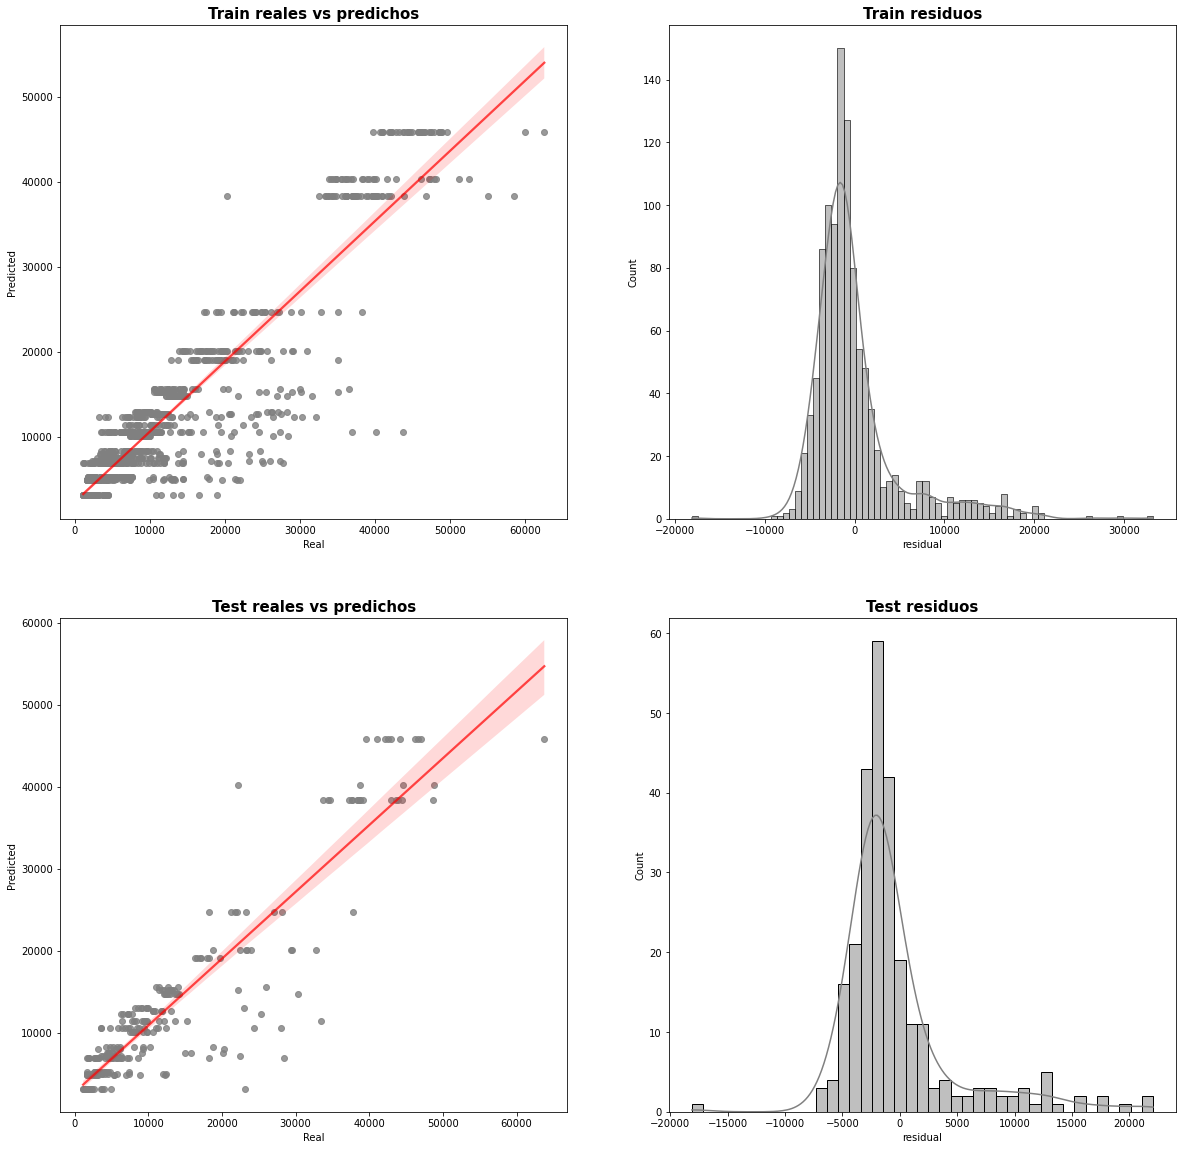

In [168]:
fig, ax = plt.subplots(2,2,figsize=(20,20))


# ploteamos los reales vs los predichos
sns.regplot(data = results[results['Set'] == "Train"], 
            x = "Real", 
            y = "Predicted", 
            ax = ax[0,0], 
            color = "grey",
            line_kws = {"color": "red", "alpha": 0.7 })


sns.regplot(data = results[results['Set'] == "Test"], 
            x = "Real",
            y = "Predicted", 
            color = "gray",
            line_kws = {"color": "red", "alpha": 0.7 }, 
            ax = ax[1,0])


# ploteamos los residuos
sns.histplot(results[results['Set'] == "Train"],
             x="residual",
             color ="grey",
             kde=True, 
             ax = ax[0,1])


sns.histplot(results[results['Set'] == "Test"],
             x="residual",
             color = "grey",
             kde=True, 
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 15, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 15, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 15, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 15, fontweight = "bold");

- Importancia predictores:

In [153]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': regressor.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values("importancia", ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
5,smoker_oe,0.593253
1,bmi,0.227266
0,age,0.126153
2,children,0.023218
3,region_encoded,0.020808
4,sex_encoded,0.009302


#### 3.2. Random Forest

In [154]:
bosque = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [157]:
%time
bosque.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


0it [00:00, ?it/s]

In [158]:
bos = bosque.best_estimator_
bos

RandomForestRegressor(max_depth=14, max_features=3, min_samples_leaf=25,
                      min_samples_split=50)

- Predicción:

In [159]:
y_pred_test_rf = bos.predict(X_test)
y_pred_train_rf = bos.predict(X_train)

In [160]:
rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,3791.552346,2.794870e+07,5286.652664,0.819975,test,Random Forest
1,3627.573588,2.713531e+07,5209.156449,0.811994,train,Random Forest


In [173]:
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_pred_train_rf, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_pred_test_rf,  'Set': ['Test']*len(y_test)})
results = pd.concat([train_df,test_df], axis = 0)

In [174]:
results['residual'] = results['Real'] - results['Predicted']

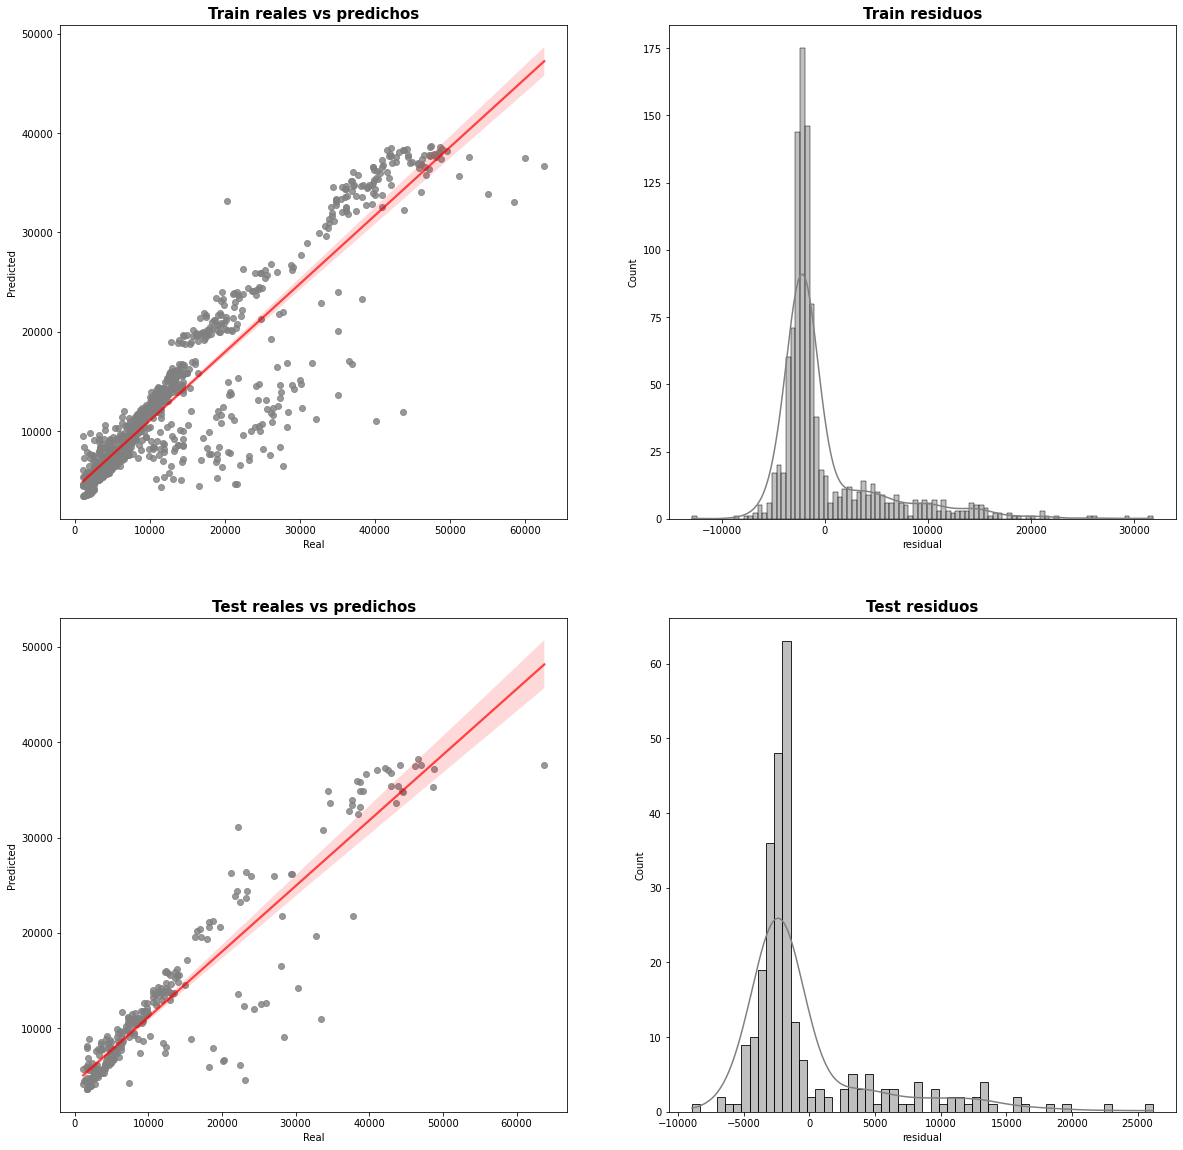

In [175]:
fig, ax = plt.subplots(2,2,figsize=(20,20))


# ploteamos los reales vs los predichos
sns.regplot(data = results[results['Set'] == "Train"], 
            x = "Real", 
            y = "Predicted", 
            ax = ax[0,0], 
            color = "grey",
            line_kws = {"color": "red", "alpha": 0.7 })


sns.regplot(data = results[results['Set'] == "Test"], 
            x = "Real",
            y = "Predicted", 
            color = "gray",
            line_kws = {"color": "red", "alpha": 0.7 }, 
            ax = ax[1,0])


# ploteamos los residuos
sns.histplot(results[results['Set'] == "Train"],
             x="residual",
             color ="grey",
             kde=True, 
             ax = ax[0,1])


sns.histplot(results[results['Set'] == "Test"],
             x="residual",
             color = "grey",
             kde=True, 
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 15, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 15, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 15, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 15, fontweight = "bold");

- Importancia predictores:

In [163]:
importancia_predictores_rf = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': bos.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_rf.sort_values("importancia", ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
5,smoker_oe,0.712806
0,age,0.138157
1,bmi,0.125941
2,children,0.011259
3,region_encoded,0.006593
4,sex_encoded,0.005244


### 4. Conclusión

In [172]:
df_all = pd.concat([df_all, rf_results ], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,3316.664104,4.010394e+07,6332.767440,0.741679,test,Decission Tree I
1,17.293618,8.986724e+04,299.778644,0.999377,train,Decission Tree I
0,3439.474738,2.537584e+07,5037.443532,0.836547,test,Decision tree II
1,3290.695161,2.525567e+07,5025.502415,0.825017,train,Decision tree II
0,3791.552346,2.794870e+07,5286.652664,0.819975,test,Random Forest
1,3627.573588,2.713531e+07,5209.156449,0.811994,train,Random Forest


Los resultados del modelo Decision tree II y Random Forest son muy similares, por lo que podríamos elegir cualquiera de los dos.